In [ ]:
import spacy
import networkx as nx
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from karateclub import Graph2Vec
from grakel import GraphKernel
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import MinMaxScaler
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load spaCy model
nlp = spacy.load('en_core_web_md')

def preprocess_text(text):
    """Lowercase the text without removing punctuation."""
    return text.lower()

def build_semantic_graph(sentence):
    """Build a semantic graph for a sentence including named entities."""
    # sentence = preprocess_text(sentence)
    doc = nlp(sentence)
    G = nx.Graph()
    for token in doc:
        G.add_node(token.i, word=token.text, pos=token.pos_, lemma=token.lemma_, dep=token.dep_)
        if token.head != token:
            G.add_edge(token.i, token.head.i, relation=token.dep_)
    for ent in doc.ents:
        G.add_node(ent.start, word=ent.text, label=ent.label_)
    return G

def convert_nx_to_grakel(graph):
    """Convert a NetworkX graph to the format required by grakel."""
    adj_matrix = nx.to_numpy_array(graph)
    node_labels = {node: graph.nodes[node]['word'] for node in graph.nodes}
    grakel_graph = (adj_matrix, node_labels)
    return grakel_graph

def create_graph_embeddings(graphs):
    """Create embeddings for a list of graphs using Graph2Vec."""
    model = Graph2Vec(dimensions=128, epochs=15, workers=4)
    model.fit(graphs)
    return model.get_embedding()

def calculate_graph_kernels(graphs):
    """Calculate graph kernels for a list of graphs."""
    grakel_graphs = [convert_nx_to_grakel(graph) for graph in graphs]
    gk = GraphKernel(kernel=["weisfeiler_lehman"], normalize=True)
    kernel_matrix = gk.fit_transform(grakel_graphs)
    return kernel_matrix

def perform_dimensionality_reduction(embeddings):
    """Reduce dimensionality of graph embeddings using t-SNE for better separation."""
    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    reduced_embeddings = tsne.fit_transform(embeddings)
    return reduced_embeddings

def scale_similarity_matrix(similarity_matrix):
    """Scale similarity matrix to ensure it lies within 0 to 1 range."""
    scaler = MinMaxScaler()
    scaled_matrix = scaler.fit_transform(similarity_matrix)
    return scaled_matrix

def semantic_aware_sparsification(sim_matrix, threshold=0.5):
    """Apply semantic-aware sparsification to the similarity matrix."""
    sparse_matrix = np.where(sim_matrix > threshold, sim_matrix, 0)
    return sparse_matrix

def contrastive_loss(sim_matrix, positive_pairs, negative_pairs):
    """Calculate contrastive loss to refine the similarity matrix."""
    pos_loss = np.sum(1 - sim_matrix[positive_pairs])  # Push positive pairs closer
    neg_loss = np.sum(sim_matrix[negative_pairs])      # Push negative pairs apart
    return pos_loss + neg_loss

def refine_similarity_matrix_with_contrastive_learning(sim_matrix):
    """Refine the similarity matrix using contrastive learning."""
    sparse_sim_matrix = semantic_aware_sparsification(sim_matrix)
    positive_pairs = np.where(sparse_sim_matrix > 0.7)
    negative_pairs = np.where(sparse_sim_matrix < 0.3)
    loss = contrastive_loss(sparse_sim_matrix, positive_pairs, negative_pairs)
    refined_matrix = sparse_sim_matrix - loss * 0.01
    refined_matrix = np.clip(refined_matrix, 0, 1)
    return refined_matrix

def calculate_inertia(similarity_matrix, k_range):
    """Calculate inertia for a range of cluster numbers."""
    inertias = []
    for k in k_range:
        clustering = AgglomerativeClustering(n_clusters=k, linkage='average')
        labels = clustering.fit_predict(1 - similarity_matrix)
        inertia = 0
        for i in range(k):
            cluster_points = similarity_matrix[np.ix_(labels == i, labels == i)]
            if len(cluster_points) > 1:
                inertia += np.sum(1 - np.dot(cluster_points, cluster_points.T))
        inertias.append(inertia)
    return inertias

def find_optimal_clusters(inertias, k_range):
    """Automatically find the optimal number of clusters using the elbow method."""
    if len(inertias) > 1:
        second_derivative = np.diff(inertias, 2)
        optimal_k = k_range[np.argmin(second_derivative) + 1]
    else:
        optimal_k = k_range[0]
    return optimal_k

def cluster_sentences(paragraph):
    """Main function to cluster sentences based on refined semantic graph similarity."""
    sentences = [sent.strip() for sent in paragraph.split('.') if sent.strip()]

    graphs = [build_semantic_graph(sent) for sent in sentences]

    if not graphs:
        print("No valid graphs to process.")
        return

    graph_embeddings = create_graph_embeddings(graphs)
    kernel_matrix = calculate_graph_kernels(graphs)
    reduced_embeddings = perform_dimensionality_reduction(graph_embeddings)

    combined_matrix = np.zeros((len(sentences), len(sentences)))
    alpha = 0.7
    beta = 0.3
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            embedding_sim = np.dot(reduced_embeddings[i], reduced_embeddings[j])
            kernel_sim = kernel_matrix[i, j]
            combined_matrix[i, j] = alpha * embedding_sim + beta * kernel_sim

    scaled_combined_matrix = scale_similarity_matrix(combined_matrix)

    # Integrate contrastive learning refinement here
    refined_similarity_matrix = refine_similarity_matrix_with_contrastive_learning(scaled_combined_matrix)

    distance_matrix = 1 - refined_similarity_matrix
    np.fill_diagonal(distance_matrix, 0)

    k_range = range(2, min(len(sentences), 10) + 1)
    inertias = calculate_inertia(refined_similarity_matrix, k_range)
    optimal_k = find_optimal_clusters(inertias, k_range)
    print(f"Optimal number of clusters: {optimal_k}")

    clustering = AgglomerativeClustering(
        n_clusters=optimal_k,
        linkage='average'
    )
    labels = clustering.fit_predict(distance_matrix)

    silhouette_avg = silhouette_score(distance_matrix, labels, metric='precomputed')
    print(f"Silhouette Score: {silhouette_avg}")

    clusters = {}
    for label, sentence in zip(labels, sentences):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(sentence)

    for cluster_id, cluster_sentences in clusters.items():
        print(f"\nCluster {cluster_id} (size {len(cluster_sentences)}):")
        for sentence in cluster_sentences:
            print(f"  - {sentence}")

    plt.figure(figsize=(10, 8))
    plt.imshow(refined_similarity_matrix, cmap='viridis')
    plt.colorbar()
    plt.title("Sentence Similarity Matrix")
    plt.show()

    linkage_matrix = linkage(distance_matrix[np.triu_indices_from(distance_matrix, k=1)], method='average')
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, labels=sentences, orientation='top', leaf_rotation=90)
    plt.title("Dendrogram for Sentence Clustering")
    plt.xlabel("Sentences")
    plt.ylabel("Distance")
    plt.show()

paragraph = """
Sloppy England shocked by Windies at World Cup. Bafta Awards 2022: Stars prepare to return to in-person ceremony. Northern Lights: Powerful aurora borealis display above Scotland. North Korea fires missile but launch fails, says South. Heathrow Airport drops Covid face mask rules. First pictures of earthquake hitting Japan. Fears Russia will not be able to pay its debts mount. Oscars 2022: The best picture nominees in 60 seconds. China plane crash: Search and rescue operation halted by rain. Rafael Nadal out for up to six weeks with rib injury. Chancellor Rishi Sunak to deliver Spring Statement amid price pressure. Ukraine conflict: What is Nato and how has it responded to Russia. Shane Warne: Australian cricket legend died from natural causes. Can tech help revive India's crumbling health system? Healy helps Australia beat Pakistan at World Cup.
"""

cluster_sentences(paragraph)


Optimal number of clusters: 3
Silhouette Score: 0.5705553005876364

Cluster 0 (size 4):
  - Optimal Order Execution subject to Reservation Strategies under Execution Risk
  - Accuracy of the mean-field theory in describing ground-state properties of light nuclei
  - Nonthermal driving forces in cells revealed by nonequilibrium fluctuations
  - Multivariate Quantiles: Geometric and Measure-Transportation-Based Contours

Cluster 2 (size 4):
  - Economic Forces in Stock Returns
  - Scaling Laws And Statistical Properties of The Transaction Flows And Holding Times of Bitcoin
  - Economic Struggles and Inflation: How Does that affect voting decision? Towards Enhanced Context Awareness with Vision-based Multimodal Interfaces
  - Consistency Based Weakly Self-Supervised Learning for Human Activity Recognition with Wearables

Cluster 1 (size 6):
  - Multi-task Heterogeneous Graph Learning on Electronic Health Records
  - A systematic dataset generation technique applied to data-driven automoti

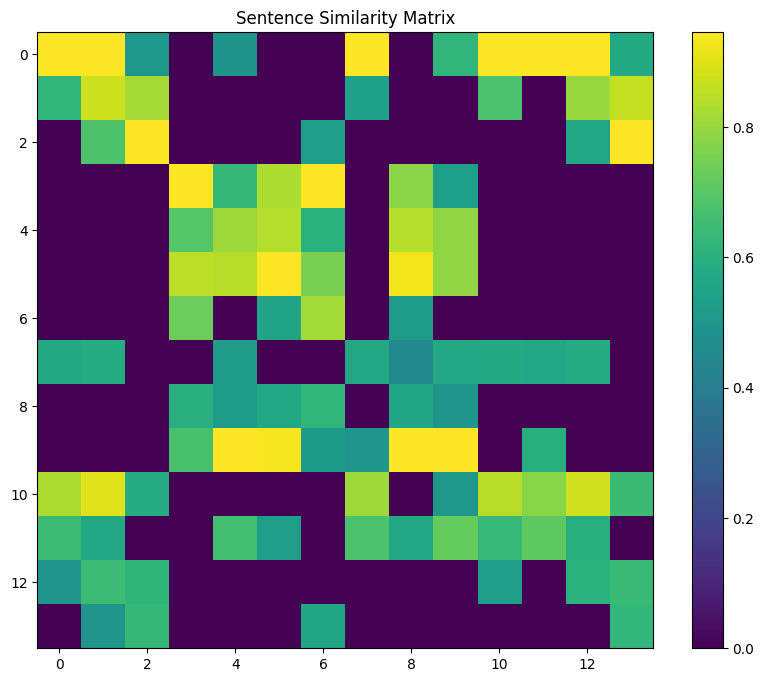

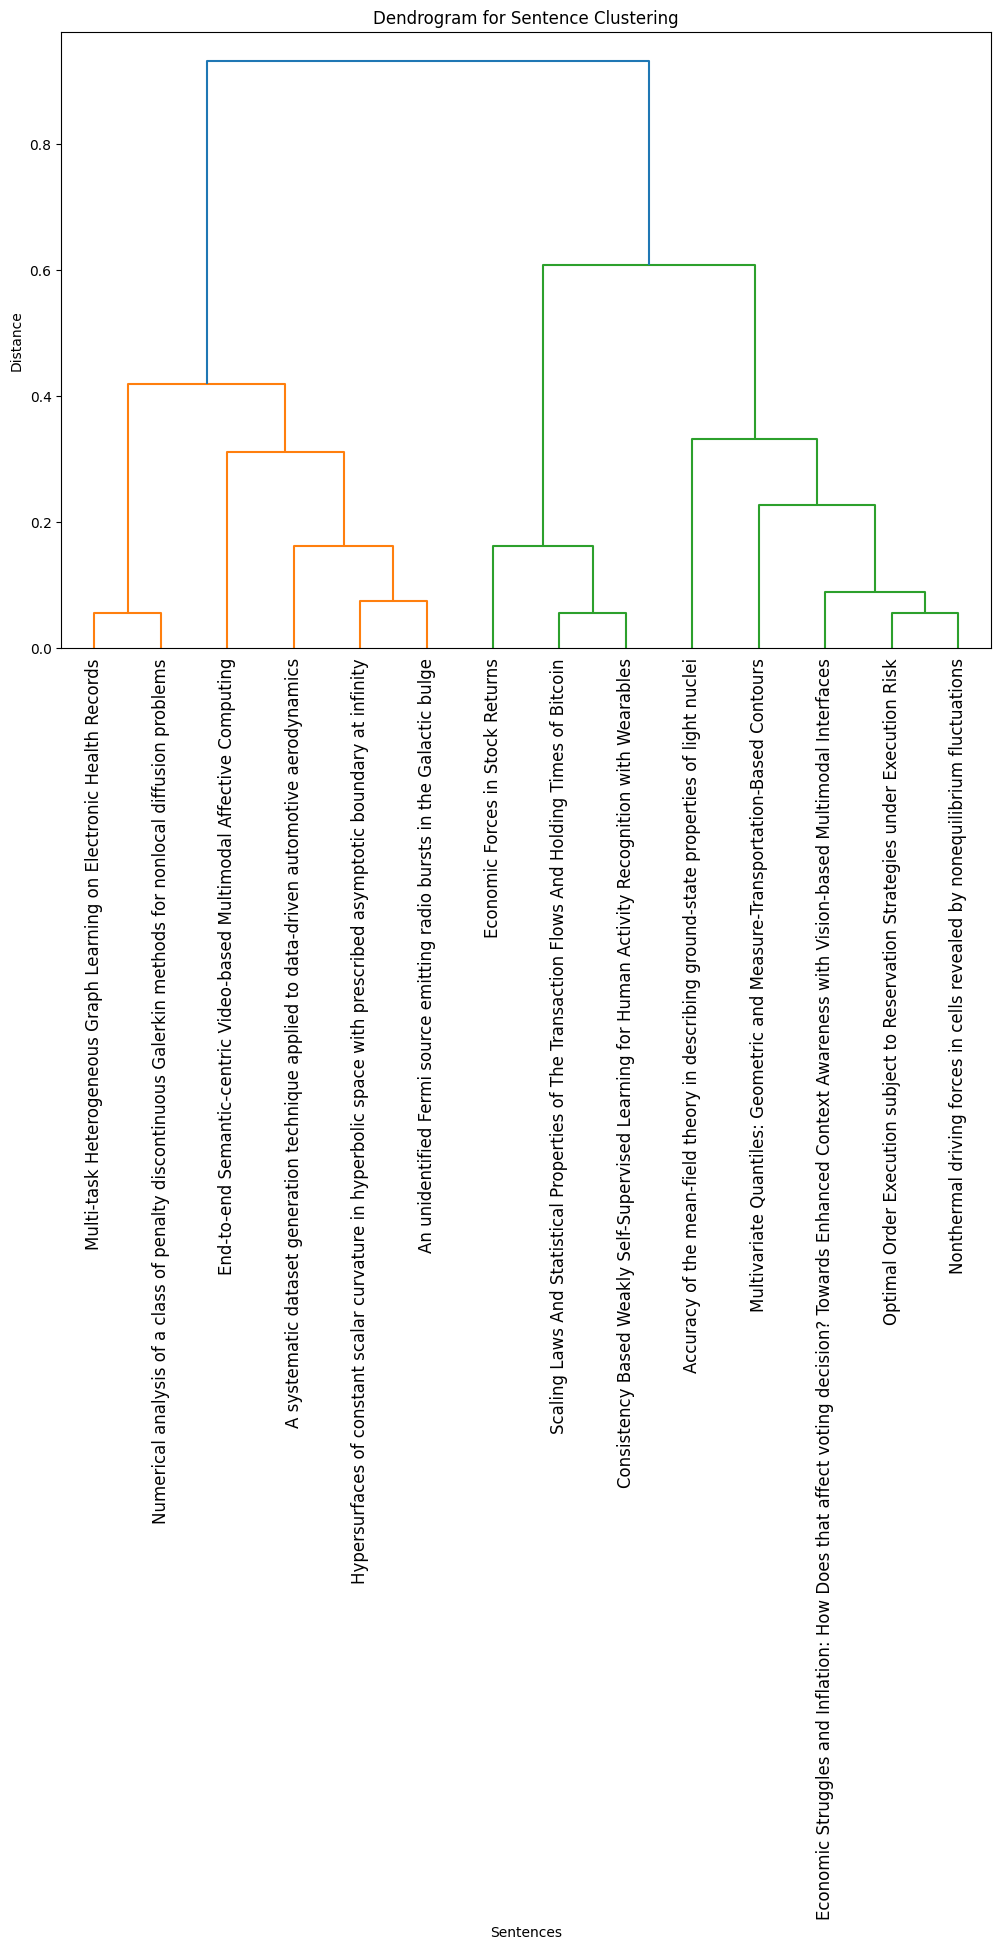

In [ ]:
paragraph = """
Optimal Order Execution subject to Reservation Strategies under Execution Risk. Economic Forces in Stock Returns. Scaling Laws And Statistical Properties of The Transaction Flows And Holding Times of Bitcoin. Multi-task Heterogeneous Graph Learning on Electronic Health Records. A systematic dataset generation technique applied to data-driven automotive aerodynamics. Hypersurfaces of constant scalar curvature in hyperbolic space with prescribed asymptotic boundary at infinity. Numerical analysis of a class of penalty discontinuous Galerkin methods for nonlocal diffusion problems. Accuracy of the mean-field theory in describing ground-state properties of light nuclei. An unidentified Fermi source emitting radio bursts in the Galactic bulge. End-to-end Semantic-centric Video-based Multimodal Affective Computing. Nonthermal driving forces in cells revealed by nonequilibrium fluctuations. Multivariate Quantiles: Geometric and Measure-Transportation-Based Contours. Economic Struggles and Inflation: How Does that affect voting decision? Towards Enhanced Context Awareness with Vision-based Multimodal Interfaces. Consistency Based Weakly Self-Supervised Learning for Human Activity Recognition with Wearables.
"""

# Run the sentence clustering function
cluster_sentences(paragraph)


Optimal number of clusters: 5
Silhouette Score: 0.06934575870871938

Cluster 0 (size 8):
  - A team of explorers travel through a wormhole in space in an attempt to ensure humanity's survival
  - A New York City police officer tries to save his estranged wife and several others taken hostage by terrorists during a Christmas party at the Nakatomi Plaza in Los Angeles
  - His innocent nature and child-like questions force the country to evaluate the impact of religious views on people
  - A writer recounts a childhood journey with his friends to find the body of a missing boy
  - A small-time Philadelphia boxer gets a supremely rare chance to fight the world heavyweight champion in a bout in which he strives to go the distance for his self-respect
  - While navigating their careers in Los Angeles, a pianist and an actress fall in love while attempting to reconcile their aspirations for the future
  - After being kicked out of his rock band, Dewey Finn becomes a substitute teacher of an u

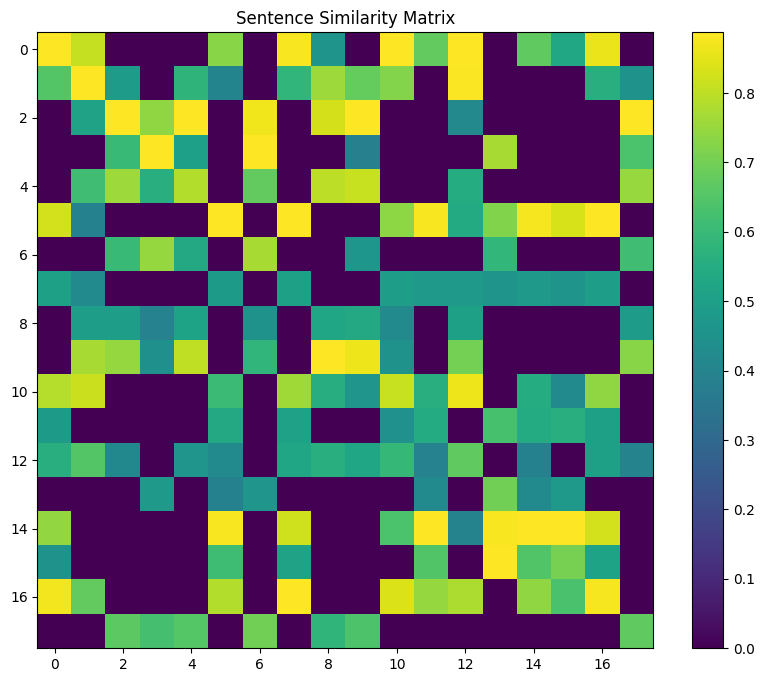

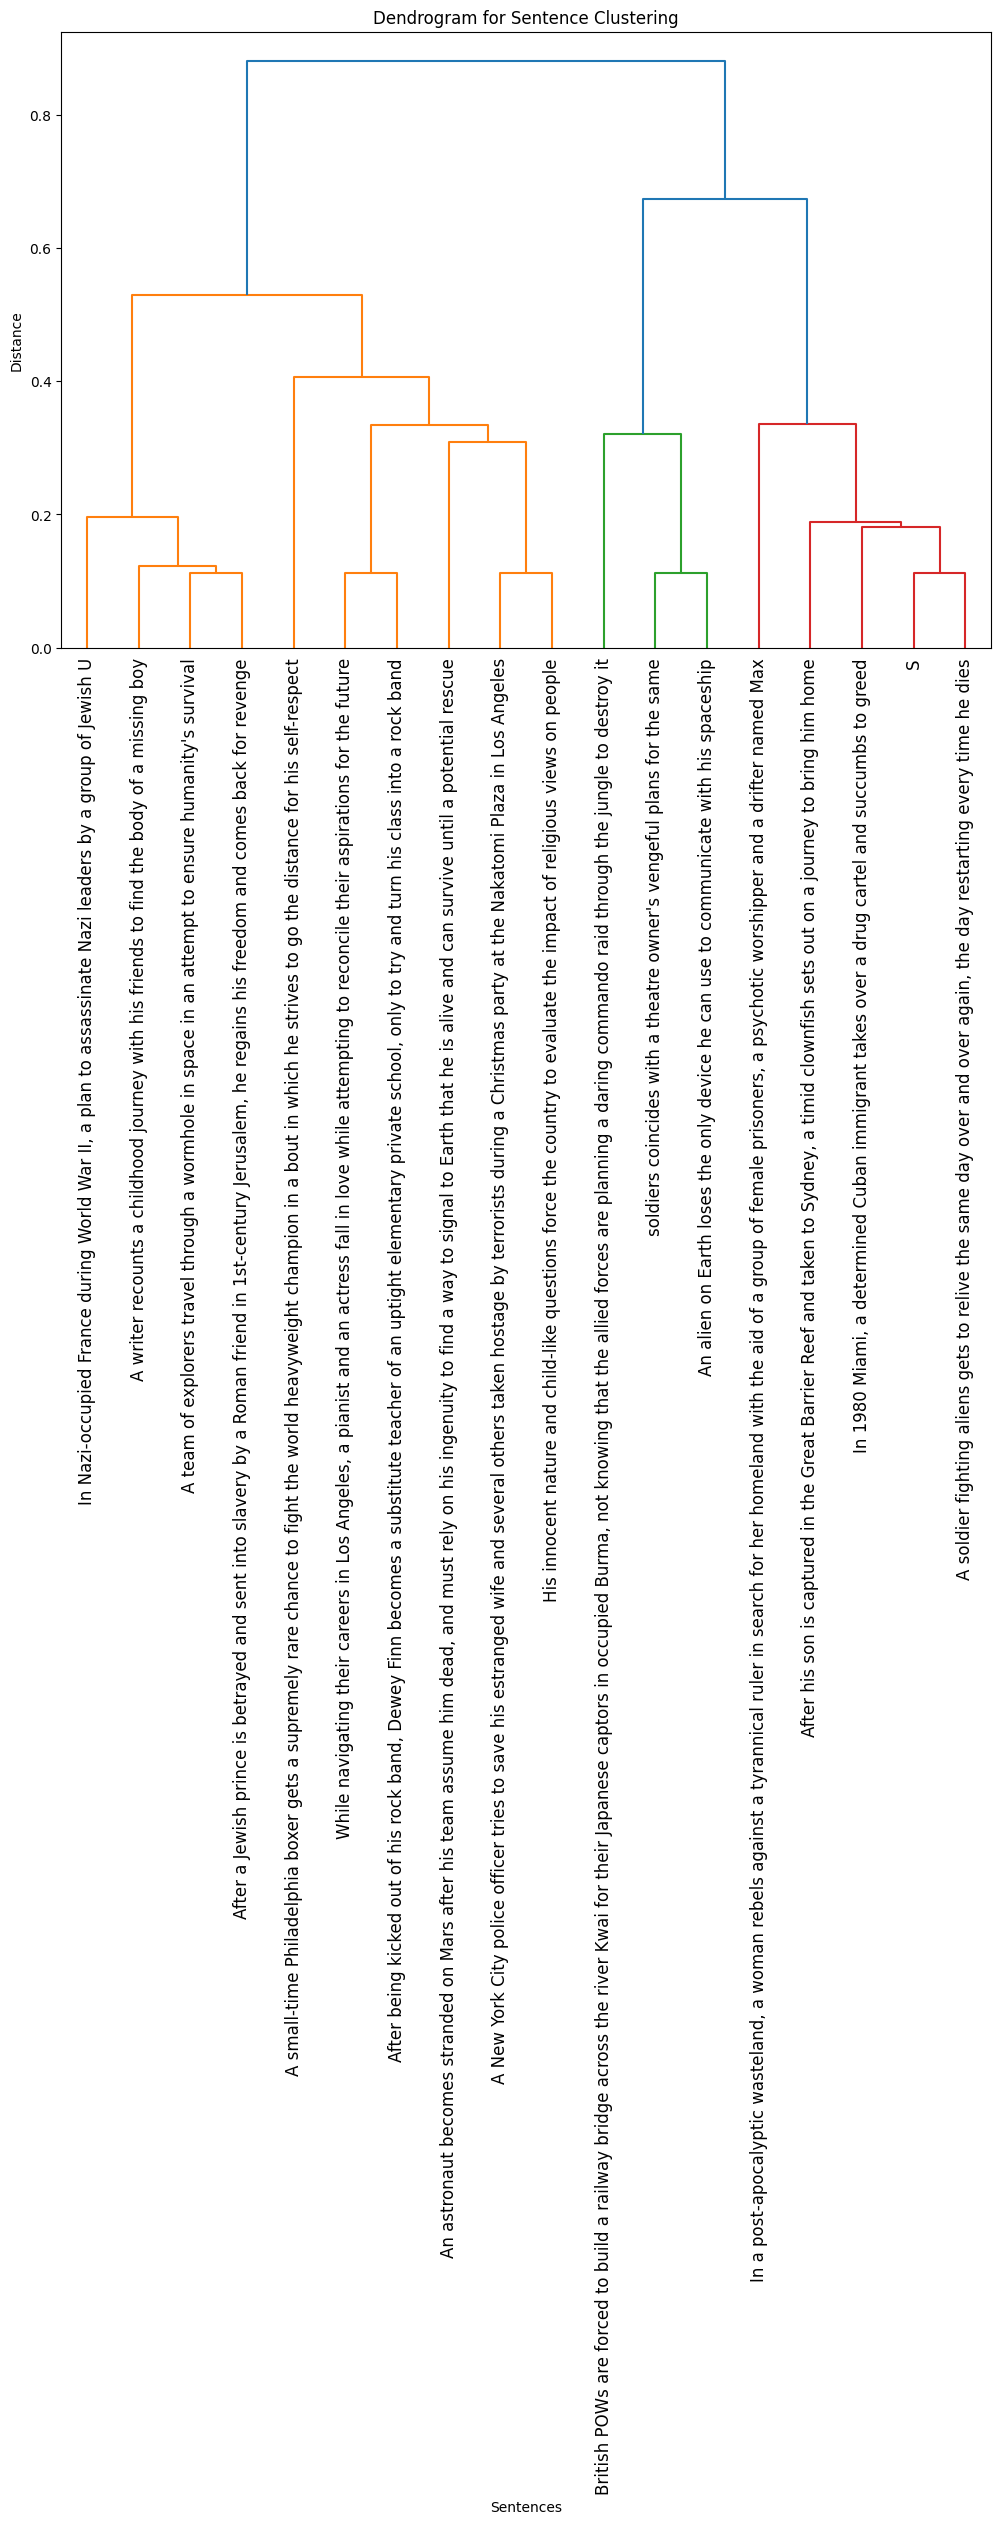

In [ ]:
paragraph = """
A team of explorers travel through a wormhole in space in an attempt to ensure humanity's survival. In Nazi-occupied France during World War II, a plan to assassinate Nazi leaders by a group of Jewish U.S. soldiers coincides with a theatre owner's vengeful plans for the same. In 1980 Miami, a determined Cuban immigrant takes over a drug cartel and succumbs to greed. A New York City police officer tries to save his estranged wife and several others taken hostage by terrorists during a Christmas party at the Nakatomi Plaza in Los Angeles. An alien on Earth loses the only device he can use to communicate with his spaceship. His innocent nature and child-like questions force the country to evaluate the impact of religious views on people. In a post-apocalyptic wasteland, a woman rebels against a tyrannical ruler in search for her homeland with the aid of a group of female prisoners, a psychotic worshipper and a drifter named Max. After his son is captured in the Great Barrier Reef and taken to Sydney, a timid clownfish sets out on a journey to bring him home. A writer recounts a childhood journey with his friends to find the body of a missing boy. A small-time Philadelphia boxer gets a supremely rare chance to fight the world heavyweight champion in a bout in which he strives to go the distance for his self-respect. After a Jewish prince is betrayed and sent into slavery by a Roman friend in 1st-century Jerusalem, he regains his freedom and comes back for revenge. British POWs are forced to build a railway bridge across the river Kwai for their Japanese captors in occupied Burma, not knowing that the allied forces are planning a daring commando raid through the jungle to destroy it. While navigating their careers in Los Angeles, a pianist and an actress fall in love while attempting to reconcile their aspirations for the future. After being kicked out of his rock band, Dewey Finn becomes a substitute teacher of an uptight elementary private school, only to try and turn his class into a rock band. An astronaut becomes stranded on Mars after his team assume him dead, and must rely on his ingenuity to find a way to signal to Earth that he is alive and can survive until a potential rescue. A soldier fighting aliens gets to relive the same day over and over again, the day restarting every time he dies.
"""

# Run the sentence clustering function
cluster_sentences(paragraph)


Optimal number of clusters: 4
Silhouette Score: 0.24036730606425788

Cluster 0 (size 4):
  - A lightweight, water-resistant backpack with multiple compartments for easy organization, ideal for travel and outdoor adventures
  - A sleek, stainless steel smartwatch with fitness tracking, GPS, and heart rate monitoring, compatible with both Android and iOS devices
  - A pair of wireless earbuds with sweat-resistant coating, perfect for workouts and high-fidelity audio playback
  - An ergonomic office chair with adjustable armrests, lumbar support, and a breathable mesh backrest

Cluster 2 (size 2):
  - A pack of 12 eco-friendly bamboo toothbrushes, biodegradable and suitable for sensitive teeth
  - A premium leather wallet with RFID protection, multiple card slots, and a coin pouch, available in different colors

Cluster 1 (size 3):
  - A noise-canceling over-ear headphone with deep bass, 30-hour battery life, and a built-in microphone for calls
  - A 4K Ultra HD smart TV with voice contro

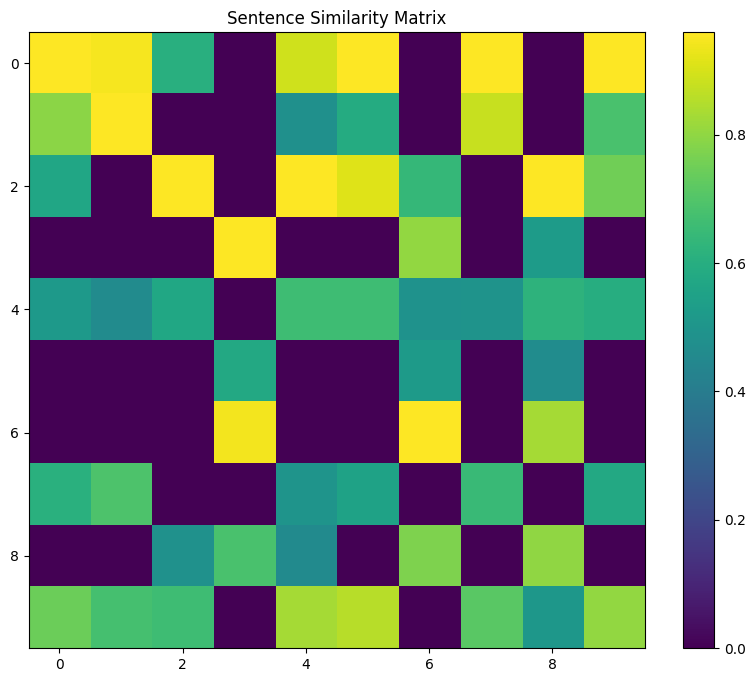

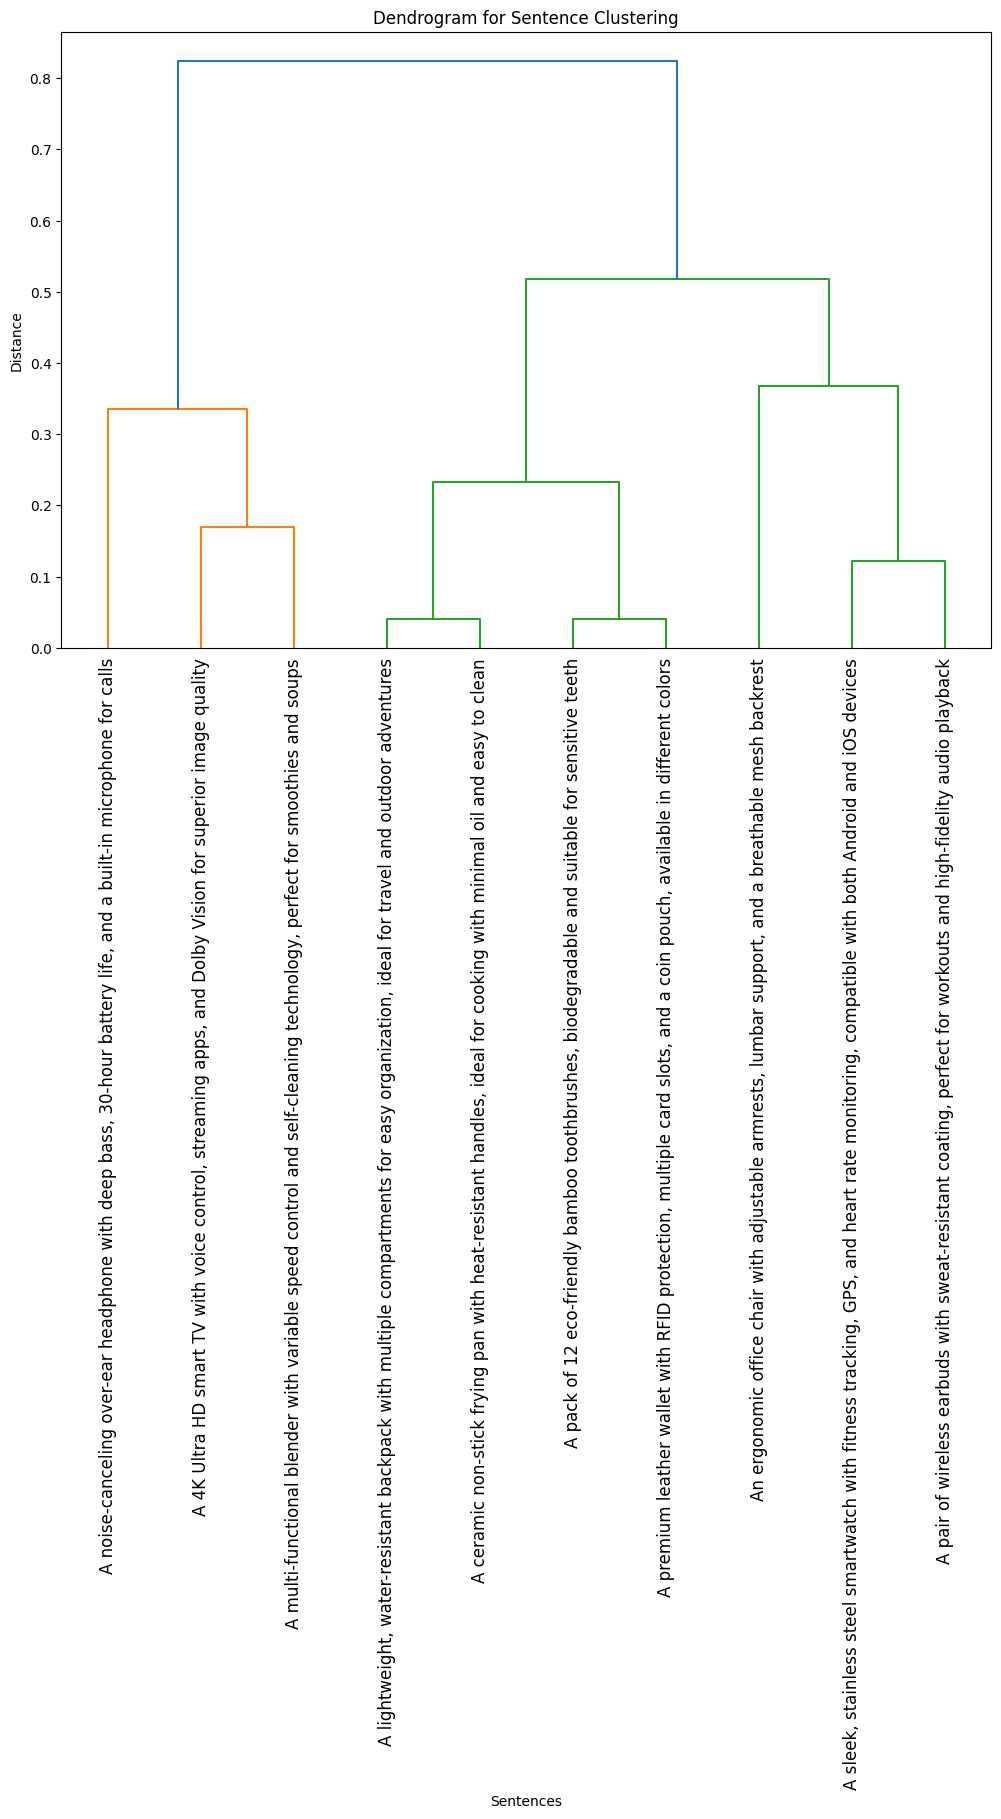

In [ ]:
paragraph = """
A lightweight, water-resistant backpack with multiple compartments for easy organization, ideal for travel and outdoor adventures. A sleek, stainless steel smartwatch with fitness tracking, GPS, and heart rate monitoring, compatible with both Android and iOS devices. A pack of 12 eco-friendly bamboo toothbrushes, biodegradable and suitable for sensitive teeth. A noise-canceling over-ear headphone with deep bass, 30-hour battery life, and a built-in microphone for calls. A premium leather wallet with RFID protection, multiple card slots, and a coin pouch, available in different colors. A ceramic non-stick frying pan with heat-resistant handles, ideal for cooking with minimal oil and easy to clean. A 4K Ultra HD smart TV with voice control, streaming apps, and Dolby Vision for superior image quality. A pair of wireless earbuds with sweat-resistant coating, perfect for workouts and high-fidelity audio playback. A multi-functional blender with variable speed control and self-cleaning technology, perfect for smoothies and soups. An ergonomic office chair with adjustable armrests, lumbar support, and a breathable mesh backrest.
"""

# Run the sentence clustering function
cluster_sentences(paragraph)


Optimal number of clusters: 7
Silhouette Score: -0.001420389996219773

Cluster 2 (size 2):
  - Looking for a software engineer proficient in Python and JavaScript to work on full-stack development with experience in Django and React
  - We are hiring a customer support specialist to manage client queries and provide exceptional service through multiple channels, including chat, phone, and email

Cluster 4 (size 1):
  - Seeking a marketing specialist with expertise in SEO, content strategy, and social media management to develop and execute digital marketing campaigns

Cluster 3 (size 1):
  - Hiring a financial analyst to perform data-driven analysis, generate financial reports, and assist in strategic decision-making

Cluster 0 (size 3):
  - Looking for a machine learning engineer experienced in building models using TensorFlow and PyTorch to work on predictive analytics projects
  - Hiring a data scientist with experience in statistical modeling, data mining, and visualization tools l

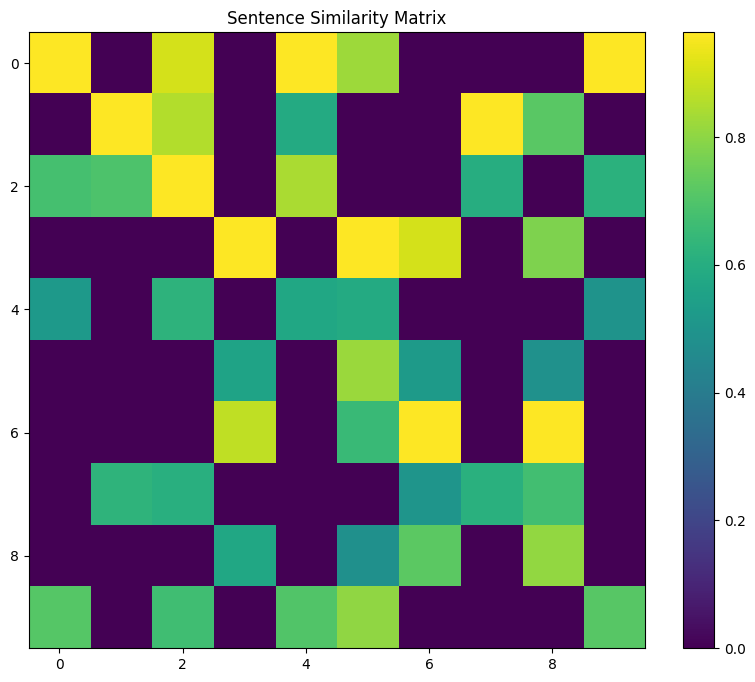

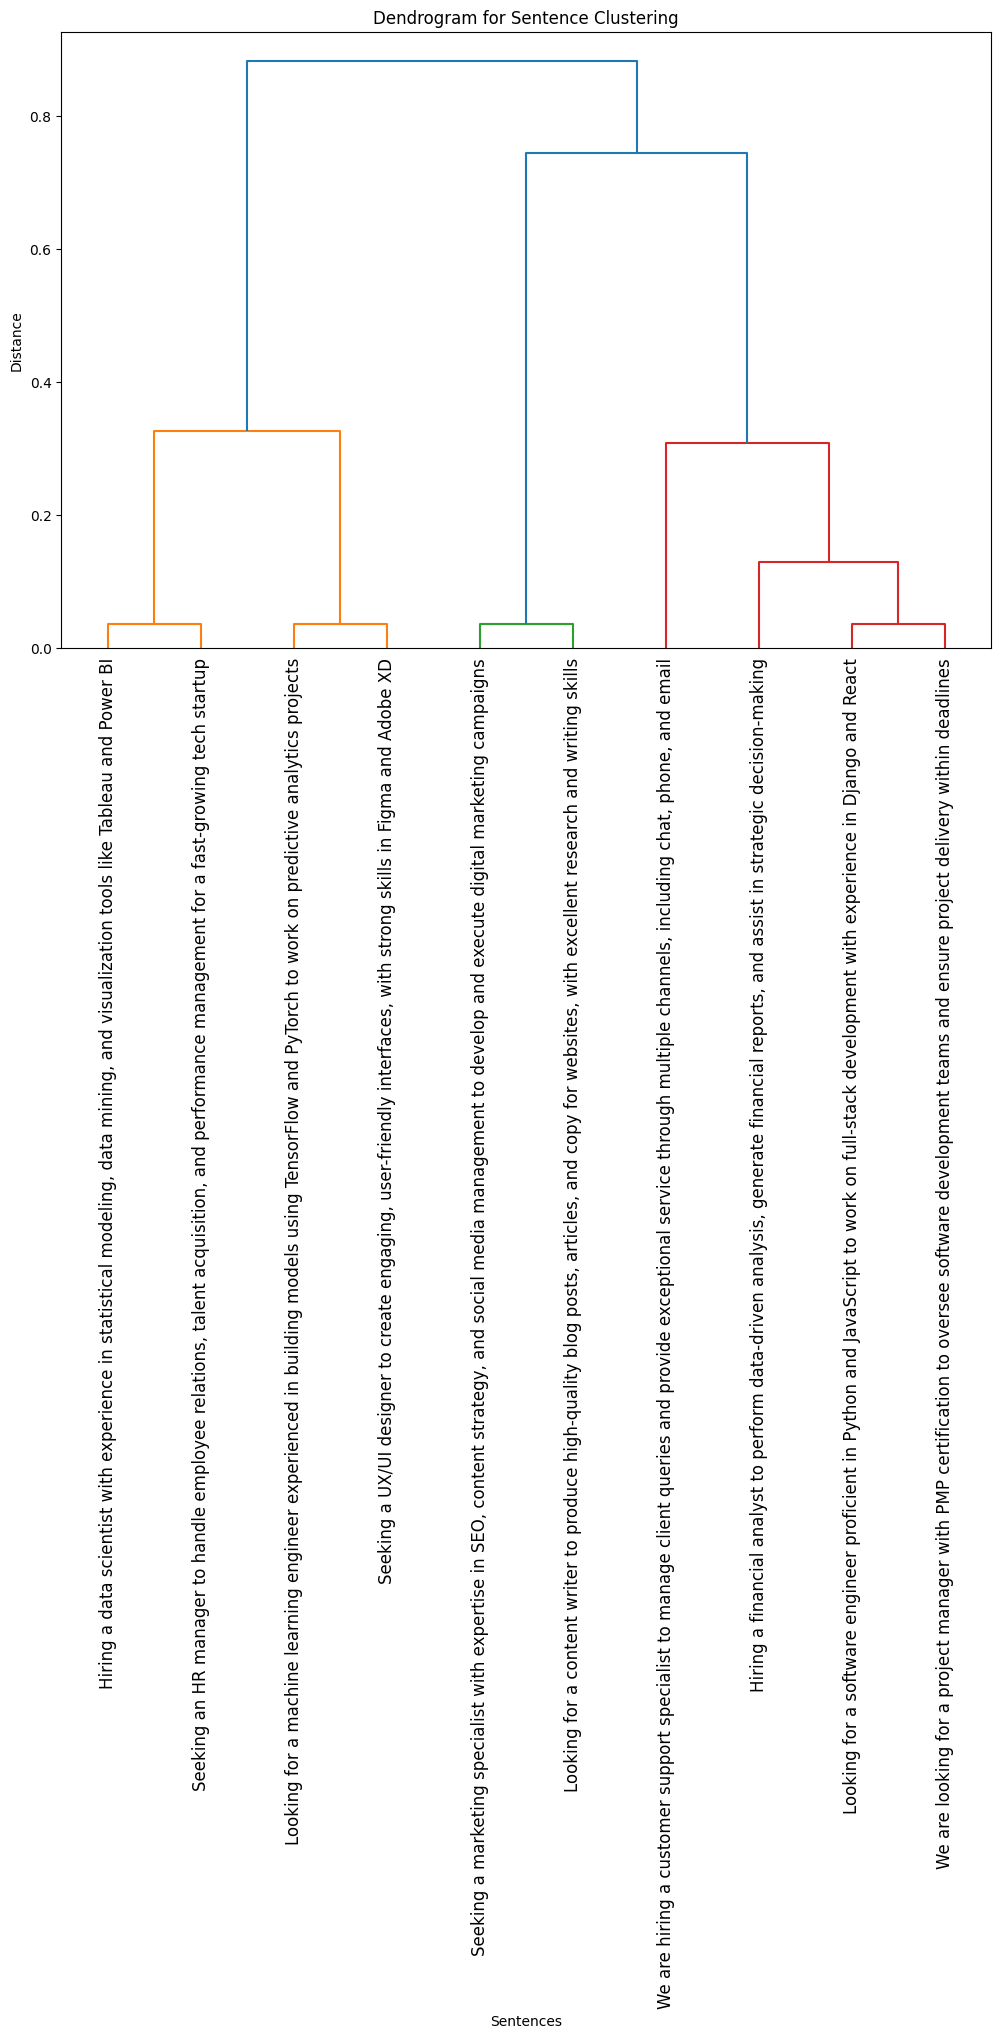

In [ ]:
paragraph = """
Looking for a software engineer proficient in Python and JavaScript to work on full-stack development with experience in Django and React. Seeking a marketing specialist with expertise in SEO, content strategy, and social media management to develop and execute digital marketing campaigns. Hiring a financial analyst to perform data-driven analysis, generate financial reports, and assist in strategic decision-making. Looking for a machine learning engineer experienced in building models using TensorFlow and PyTorch to work on predictive analytics projects. We are looking for a project manager with PMP certification to oversee software development teams and ensure project delivery within deadlines. Seeking a UX/UI designer to create engaging, user-friendly interfaces, with strong skills in Figma and Adobe XD. Hiring a data scientist with experience in statistical modeling, data mining, and visualization tools like Tableau and Power BI. Looking for a content writer to produce high-quality blog posts, articles, and copy for websites, with excellent research and writing skills. Seeking an HR manager to handle employee relations, talent acquisition, and performance management for a fast-growing tech startup. We are hiring a customer support specialist to manage client queries and provide exceptional service through multiple channels, including chat, phone, and email.
"""

# Run the sentence clustering function
cluster_sentences(paragraph)
